# Install and Import Required Libraries

In [1]:
# Install required libraries
!pip install darts pmdarima

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darts import TimeSeries
from darts.models import ARIMA, AutoARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load Preprocessed Data

In [2]:
# Mount Google Drive (for accessing data in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/total_data_guayas_region.csv')

# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df.head()

,store_nbr,item_nbr,date,unit_sales,year,month,day,day_of_week,lag_1,lag_7,lag_14,rolling_avg_7,rolling_stdv_7
0,24,105574,2013-01-16,19.0,2013,1,16,2,3.0,7.0,12.0,5.857143,6.175990
1,24,105574,2013-01-17,7.0,2013,1,17,3,19.0,3.0,1.0,6.428571,6.051367
2,24,105574,2013-01-18,8.0,2013,1,18,4,7.0,6.0,3.0,6.714286,6.074929
3,24,105574,2013-01-19,5.0,2013,1,19,5,8.0,7.0,4.0,6.428571,6.106203
4,24,105574,2013-01-20,3.0,2013,1,20,6,5.0,1.0,7.0,6.714286,5.851333


# Filter Data for a Specific Store & Item

In [4]:
# Filter for a specific store, item, and date range
df_filtered = df[(df['store_nbr'] == 24) & (df['item_nbr'] == 105574)][['date', 'unit_sales']]

# Set 'date' as the index again
df_filtered.set_index('date', inplace=True)

print(df_filtered.head())

            unit_sales
date                  
2013-01-16        19.0
2013-01-17         7.0
2013-01-18         8.0
2013-01-19         5.0
2013-01-20         3.0


# Time Series Visualization

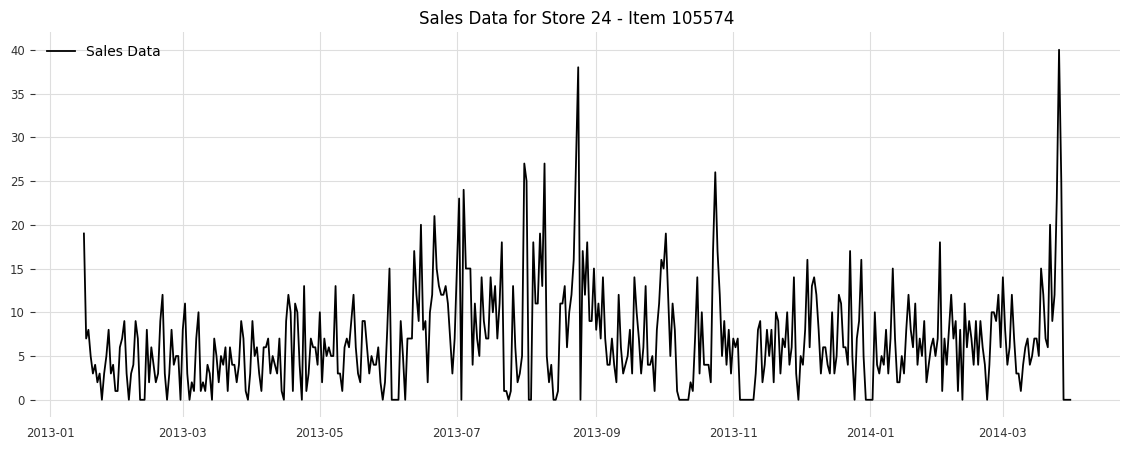

In [5]:
# Plot the sales data
plt.figure(figsize=(14,5))
plt.plot(df_filtered, label='Sales Data')
plt.title('Sales Data for Store 24 - Item 105574')
plt.legend()
plt.show()

# Seasonal Decomposition of Sales Data for Store 24 - Item 105574



<Figure size 2000x800 with 0 Axes>

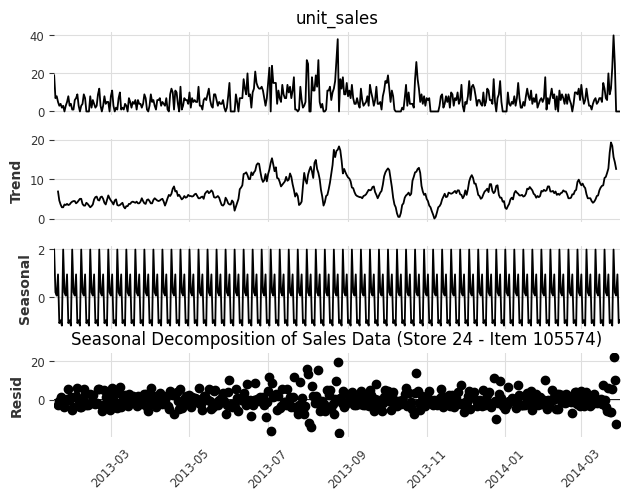

In [6]:
# Import seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the filtered time series data
result = seasonal_decompose(df_filtered['unit_sales'], model='additive', period=7) # Set the period to 7 for weekly seasonality

# Plot the components of the decomposition
plt.figure(figsize=(20, 8))
result.plot()
plt.xticks(rotation=45)
plt.title('Seasonal Decomposition of Sales Data (Store 24 - Item 105574)')
plt.show()


# Check for Stationarity using ADF Test

In [7]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

# Apply the test
adf_test(df_filtered['unit_sales'])


ADF Statistic: -3.339590648932333
p-value: 0.013198898837129346
Stationary


# Identify ARIMA Parameters using ACF & PACF

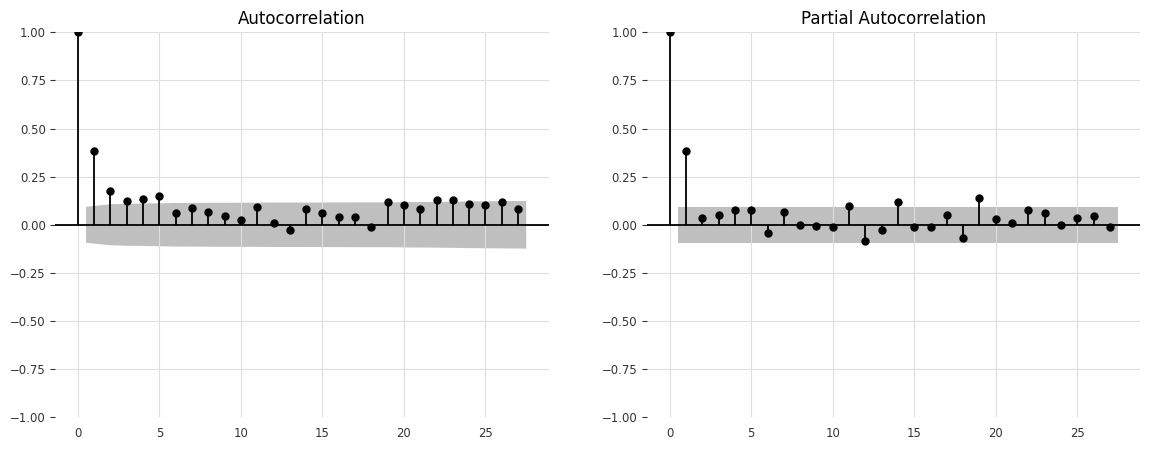

In [8]:
# Plot ACF and PACF
fig, axes = plt.subplots(1,2, figsize=(14,5))
plot_acf(df_filtered['unit_sales'], ax=axes[0])
plot_pacf(df_filtered['unit_sales'], ax=axes[1])
plt.show()


# Train-Test Split

In [9]:
# Split data into train (80%) and test (20%)
train_size = int(len(df_filtered) * 0.8)
train, test = df_filtered[:train_size], df_filtered[train_size:]

# Convert to Darts TimeSeries format
ts_train = TimeSeries.from_series(train['unit_sales'])
ts_test = TimeSeries.from_series(test['unit_sales'])


# Find Best ARIMA Parameters using auto_arima

In [10]:
# Step 1: Find the best ARIMA parameters using auto_arima
best_model = auto_arima(train['unit_sales'], seasonal=True, m=7, stepwise=True, trace=True)

# Print the best parameters found by auto_arima
print("Best ARIMA parameters found by auto_arima:")
print(best_model.summary())

# Extract ARIMA parameters
best_p, best_d, best_q = best_model.order
best_P, best_D, best_Q, best_m = best_model.seasonal_order

# Print the best ARIMA parameters
print(f"Best ARIMA parameters: p={best_p}, d={best_d}, q={best_q}")
print(f"Best seasonal parameters: P={best_P}, D={best_D}, Q={best_Q}, m={best_m}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=9.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2298.373, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2255.792, Time=0.75 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=2191.869, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2296.399, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=2192.244, Time=0.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=2193.667, Time=2.69 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=2193.785, Time=3.54 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=2191.937, Time=1.48 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=2195.663, Time=4.98 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2300.344, Time=0.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=2171.582, Time=1.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=2169.728, Time=4.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=2171.573, Time=2.87 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=2172.722, Time=3.61 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=2254.449, Time=0.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=2171.719, Time=1.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=2171.716, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=2171.858, Time=0.27 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=2228.131, Time=0.38 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=4.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[7]             : AIC=2167.754, Time=0.52 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=2169.597, Time=0.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7]             : AIC=2169.606, Time=1.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[7]             : AIC=2170.747, Time=1.71 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=2190.289, Time=0.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[7]             : AIC=2252.486, Time=0.11 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7]             : AIC=2169.745, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[7]             : AIC=2169.743, Time=0.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[7]             : AIC=2169.869, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[7]             : AIC=2226.183, Time=0.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[7]             : AIC=inf, Time=0.53 sec

Best model:  ARIMA(1,1,1)(0,0,0)[7]          
Total fit time: 50.746 seconds
Best ARIMA parameters found by auto_arima:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  352
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1080.877
Date:                Sun, 23 Mar 2025   AIC                           2167.754
Time:                        11:24:26   BIC                           2179.337
Sample:                    01-16-2013   HQIC                          2172.364
                         - 01-02-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3012      0

# Train and Predict using ARIMA

In [11]:
# Train ARIMA model
p = 1
d = 1
q = 1

arima_model = ARIMA(p=p, d=d, q=q)
arima_model.fit(ts_train)
forecast_arima = arima_model.predict(len(ts_test))

# Train and Predict using SARIMA

In [12]:
from darts.models import ARIMA
import matplotlib.pyplot as plt

# Manually set ARIMA (p, d, q) and seasonal parameters (P, D, Q, m)
p = 1  # Non-seasonal AR order
d = 1  # Non-seasonal differencing order
q = 1  # Non-seasonal MA order

P = 0  # Seasonal AR order
D = 0  # Seasonal differencing order
Q = 0  # Seasonal MA order
m = 7  # Seasonal period (weekly seasonality)

# Initialize the ARIMA model with both non-seasonal and seasonal parameters
sarima_like_model = ARIMA(p=p, d=d, q=q, seasonal_order=(P, D, Q, m))

# Fit the ARIMA model with seasonality on the training data
sarima_like_model.fit(ts_train)

# Forecast the next values (the same length as the test set)
sarima_forecast = sarima_like_model.predict(len(test))

# Evaluate Model Performance

In [13]:
import numpy as np

In [14]:
# Calculate ARIMA performance
mae_arima = mean_absolute_error(test, forecast_arima.pd_series())
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima.pd_series()))
print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}')

# Calculate SARIMA performance
mae_sarima = mean_absolute_error(test, sarima_forecast.pd_series())
rmse_sarima = np.sqrt(mean_squared_error(test, sarima_forecast.pd_series()))
print(f'SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}')

ARIMA - MAE: 3.818455014937943, RMSE: 6.079187468750066
SARIMA - MAE: 3.818455014937943, RMSE: 6.079187468750066


# Plot Forecast vs Actual Data

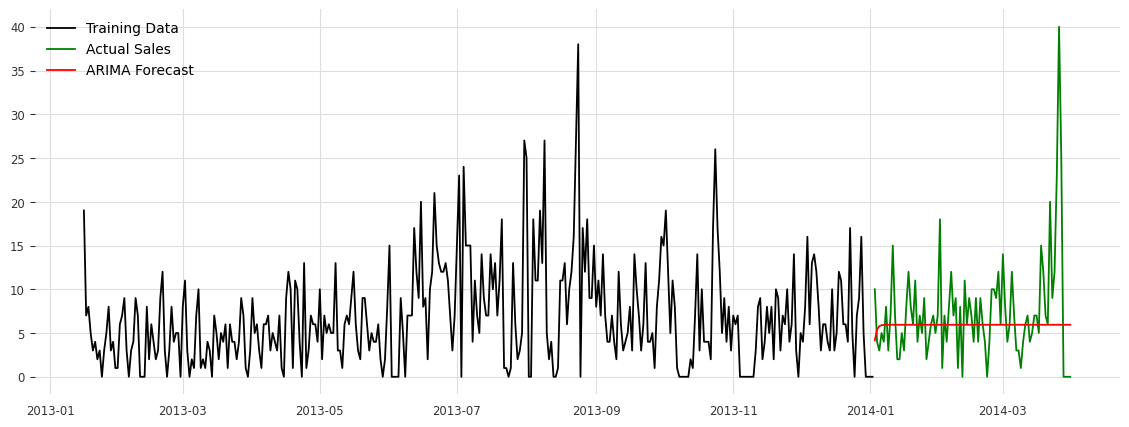

In [15]:
# Plot the forecasts along with actual data
plt.figure(figsize=(14,5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Sales', color='green')
plt.plot(forecast_arima.pd_series(), label='ARIMA Forecast', color='red')
plt.legend()
plt.show()

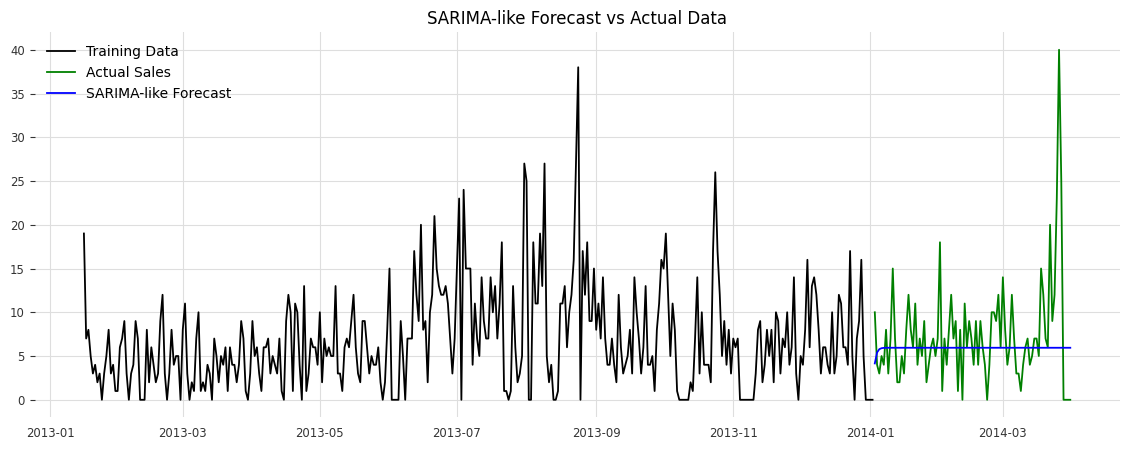

In [16]:
# Plot the forecasts along with actual data
plt.figure(figsize=(14,5))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Sales', color='green')
plt.plot(sarima_forecast.pd_series(), label='SARIMA-like Forecast', color='blue')  # Use the SARIMA-like forecast
plt.legend()
plt.title('SARIMA-like Forecast vs Actual Data')
plt.show()